In [1]:
from google.colab import files

upload = files.upload()

Saving DailyDelhiClimateTrain.csv to DailyDelhiClimateTrain.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import iplot, init_notebook_mode
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import datetime as dt

In [3]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet,Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
import xgboost as xgb

In [15]:
df = pd.read_csv('DailyDelhiClimateTrain.csv')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [17]:
df.round(2).sample(5)

,date,meantemp,humidity,wind_speed,meanpressure
118,2013-04-29,32.12,26.38,7.88,1004.88
1187,2016-04-02,32.31,38.56,5.46,1008.00
240,2013-08-29,31.50,57.00,9.28,1003.25
20,2013-01-21,11.20,77.00,2.22,1021.00
377,2014-01-13,14.00,72.38,1.16,1019.38


In [18]:
print('Number of instances = ',df.shape[0])
print('Number of attributes = ',df.shape[1],"\n")
# To get then number of missing values
print(df.isna().sum())

Number of instances =  1462
Number of attributes =  5 

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64


<ipython-input-25-56f8b2447f0a>:5: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



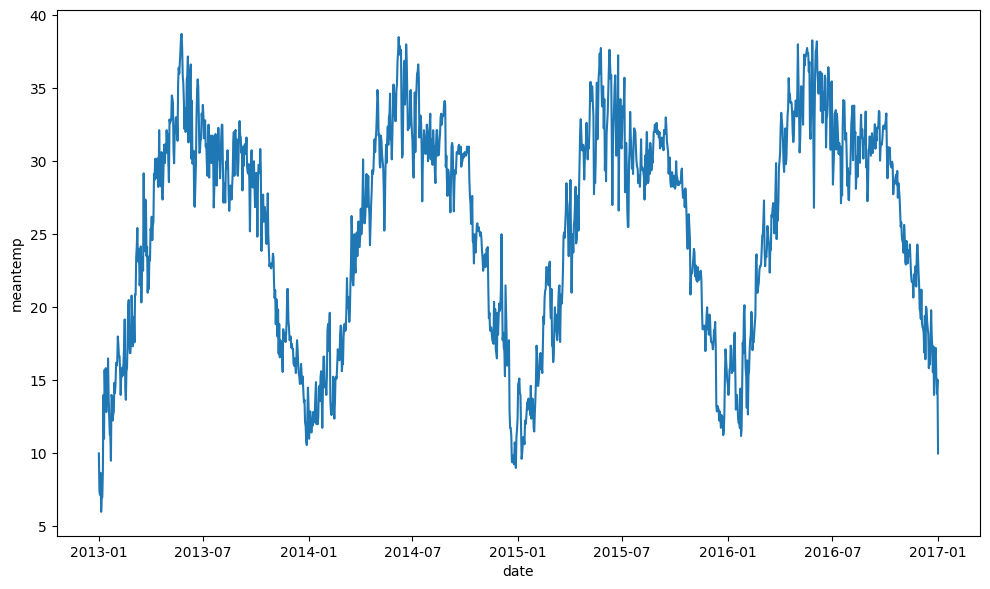

In [25]:
df['date'] = pd.to_datetime(df['date'])


fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x='date', y='meantemp',palette="rainbow", data=df, ax=ax)


# Display the plot
plt.tight_layout()
plt.show()

In [27]:
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')

In [28]:
df['dayOfWeek'] = df['date'].dt.dayofweek
df['year']=df['date'].dt.year
df['day']=df['date'].dt.day
df['month']=df['date'].dt.month

In [29]:
numeric_features = []
for column in df.columns:
    if df[column].dtype == 'float64':
        numeric_features.append(column)

print("Attributes with data type float64:")
print(numeric_features)

Attributes with data type float64:
['meantemp', 'humidity', 'wind_speed', 'meanpressure']


In [30]:
correlation = df.corr()
print(correlation['meantemp'].sort_values(ascending = False),'\n')

meantemp        1.000000
wind_speed      0.306468
month           0.122667
year            0.103803
day             0.006475
dayOfWeek      -0.009941
meanpressure   -0.038818
humidity       -0.571951
Name: meantemp, dtype: float64 



<ipython-input-30-7b8b63e84f6c>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<ipython-input-31-9f956797e6a5>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



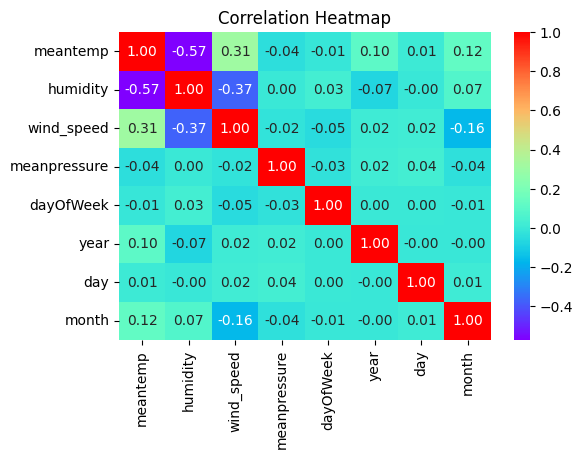

In [31]:
# Calculate correlation matrix
corr_matrix = df.corr()

# Create heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True,cmap='rainbow', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Heatmap')
plt.show()

In [34]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.8 MB/s eta 0:00:00


In [35]:
import pmdarima as pm
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


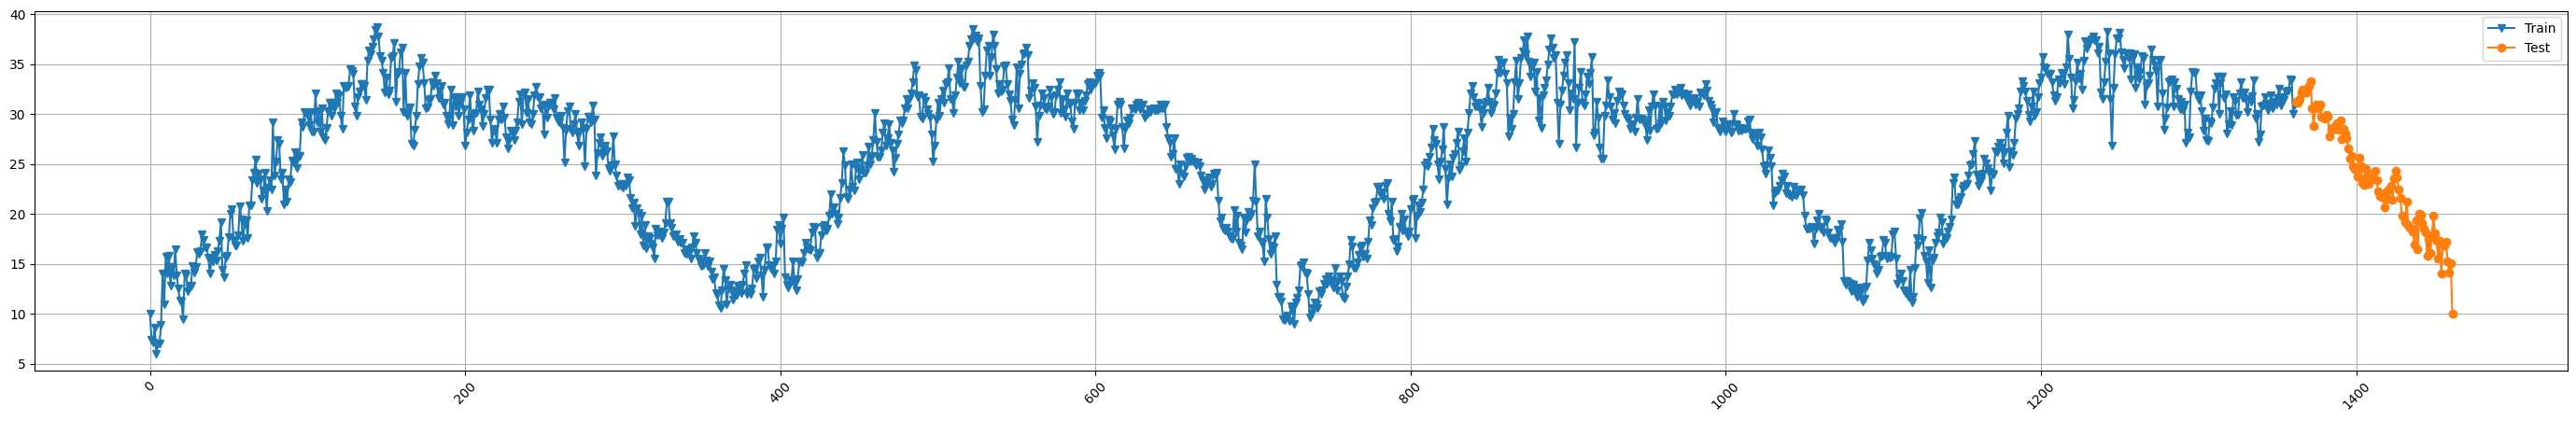

In [36]:
X = df.drop(columns=['meantemp'])  # Features (excluding the target variable)
Y = df['meantemp']  # Target variable (mean temperature)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=100, shuffle=False)

plt.figure(figsize=(35, 5))
plt.grid()

# Plot train set
plt.plot(x_train.index, y_train, marker='v', label='Train')

# Plot test set
plt.plot(x_test.index, y_test, marker='o', label='Test')

plt.xticks(rotation=45)
plt.legend()
plt.show()


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4]             : AIC=inf, Time=9.86 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=6425.399, Time=0.19 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=5979.927, Time=0.77 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=inf, Time=2.17 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=5978.702, Time=0.08 sec
 ARIMA(1,2,0)(0,0,1)[4]             : AIC=5979.960, Time=0.19 sec
 ARIMA(1,2,0)(1,0,1)[4]             : AIC=5980.520, Time=0.53 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=5832.336, Time=0.14 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=5831.983, Time=0.21 sec
 ARIMA(2,2,0)(2,0,0)[4]             : AIC=5833.948, Time=0.33 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=5833.285, Time=0.81 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=5832.006, Time=0.22 sec
 ARIMA(2,2,0)(2,0,1)[4]             : AIC=5834.790, Time=1.61 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=5543.828, Time=0.40 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=5

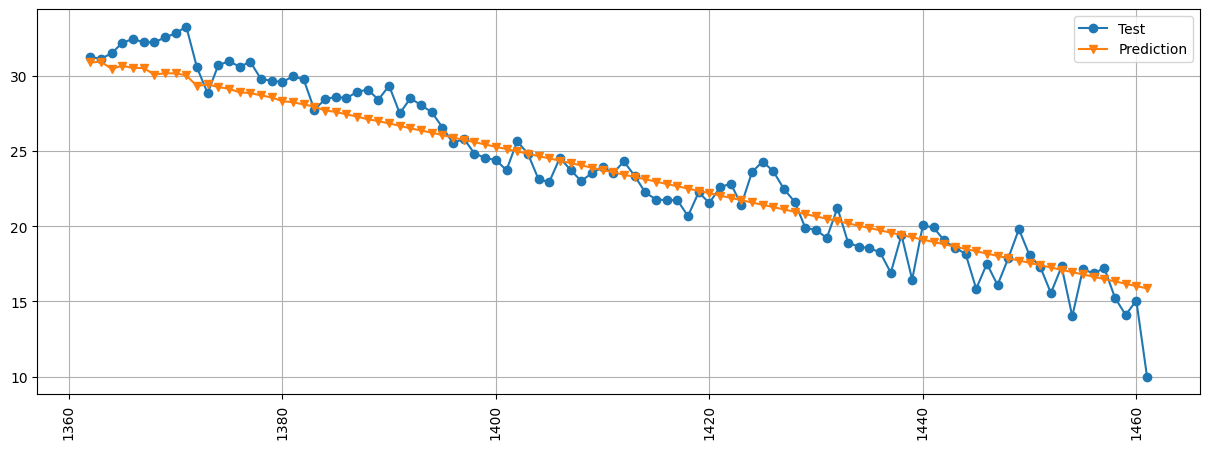

Mean Absolute Percentage Error: 0.05594606603916466
Mean Squared Error: 2.277060861384478
Root Mean Squared Error: 1.5089933271504146
AIC: 5469.426225916859


In [41]:
# Fit a simple auto_arima model
arima = pm.auto_arima(y_train, exogenous=x_train.drop(columns=['date']), d=2, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=500, m=4, stationary=False, test='adf')

# Print out summary information on the fit
print(arima.summary())
print(arima.params)

# Generate predictions
pred = arima.predict(n_periods=100, exogenous=x_test.drop(columns=['date']), alpha=0.05)

plt.figure(figsize=(15,5))
plt.grid()

# Plot actual test values
plt.plot(x_test.index, y_test, marker='o', label='Test')

# Plot predicted values
plt.plot(x_test.index, pred, marker='v', label='Prediction')

plt.legend()
plt.xticks(rotation=90)
plt.show()

print("="*50)
print("="*50)

# Calculate evaluation metrics
mape = mean_absolute_percentage_error(y_test, pred)
print("Mean Absolute Percentage Error:", mape)
print("="*50)
mse = mean_squared_error(y_test, pred)
print("Mean Squared Error:", mse)
print("="*50)
print("Root Mean Squared Error:", mse ** 0.5)
print("="*50)
print("AIC:", arima.aic())

<ipython-input-40-0a7d73d3ec99>:5: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

<ipython-input-40-0a7d73d3ec99>:8: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



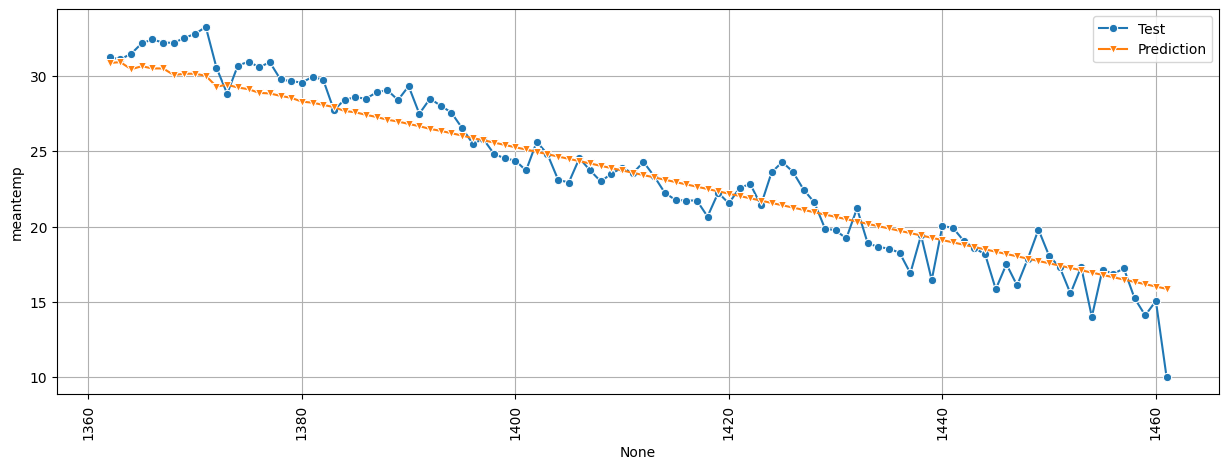

Mean Absolute Percentage Error: 0.05594606603916466
Mean Squared Error: 2.277060861384478
Root Mean Squared Error: 1.5089933271504146
AIC: 5469.426225916859


In [40]:
plt.figure(figsize=(15,5))
plt.grid()

# Plot actual test values
sns.lineplot(x=x_test.index, y=y_test,palette="rainbow", marker='o', label='Test')

# Plot predicted values
sns.lineplot(x=x_test.index, y=pred,palette="rainbow", marker='v', label='Prediction')

plt.legend()
plt.xticks(rotation=90)
plt.show()

print("="*50)
print("="*50)

# Calculate evaluation metrics
mape = mean_absolute_percentage_error(y_test, pred)
print("Mean Absolute Percentage Error:", mape)
print("="*50)
mse = mean_squared_error(y_test, pred)
print("Mean Squared Error:", mse)
print("="*50)
print("Root Mean Squared Error:", mse ** 0.5)
print("="*50)
print("AIC:", arima.aic())